<a href="https://colab.research.google.com/github/heokwon/DietService-ObjectDetection/blob/main/Final_train_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구글 드라이브 마운트

In [ ]:
from google.colab import drive # content에서 drive사용
drive.mount('/content/drive')

Mounted at /content/drive


# 전처리된 이미지파일 압축풀기

In [ ]:
%cd /content/drive/MyDrive/Image_project/Image # 전처리된 데이터가 모여있는 폴더로 경로설정

/content/drive/MyDrive/Image_project/Image


In [ ]:
# !unzip -qq /content/drive/MyDrive/Image.zip # unzip을 사용하여 전처리데이터 zip파일 압축해제

# 데이터 개수확인(이미지 12740 + 바운딩박스 텍스트파일 12740)

In [ ]:
import glob # glob모듈
dir = '/content/drive/MyDrive/Image_project/Image' # 경로를 dir변수에 저장
temp = glob.glob(dir+'/*') # glob함수 사용하여 dir(경로) 하위 파일들을 리스트로 저장 후 temp변수로 저장
len(temp) # 리스트로 저장한 데이터들의 개수 ( img + txt 개수 : 25480개 // 각각 12740개씩 )

25480

# 필요한 라이브러리 import

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


# 다크넷 가져오기

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


# classNames.names 파일생성

In [ ]:
f = open('/content/drive/MyDrive/Image_project/category.txt','r')
lines = f.readlines()
f.close()
data = []
count = 0
f = open('/content/drive/MyDrive/darknet/data/ClassNames.names', 'w')
for line in lines:
  if count==0: 
    count+=1
    continue
  temp = line.split('\t')[1].split('\n')[0]+'\n'
  f.write(temp)
f.close()

# 각 이미지 경로 가져오기

In [ ]:
import glob
dir = '/content/drive/MyDrive/Image_project/Image'
file_list = glob.glob(dir+'/*.jpg') # 경로 하위 파일 중 .jpg로 끝나는 파일들을 리스트로 변환 뒤 file_list변수로 저장

In [ ]:
len(file_list) # .jpg파일 개수세기 12740개

12740

# train,test,validation 데이터 나누기
80:10:10 train,test,validation으로 나누었음
계통추출법을 사용하여 5의 배수는 validation으로
10의 배수는 test으로 나눔

In [ ]:
train = [] # 불러온 이미지 데이터를 학습시키기위해 각각 train,valid,test set으로 저장
valid = [] # 일단 train,valid,test 빈 리스트 생성
test = []
for i in range(len(file_list)): # file_list(12740)개 범위에서
  if i %10 ==0: 
    test.append(file_list[i]) # test set 10%
  elif i % 5 ==0:
    valid.append(file_list[i])# valid set 10%
  else:
    train.append(file_list[i])# 나머지 80%는 train 리스트에 추가하여 전체 이미지 중 10%의 test,valid set과 80%의 train set 생성

In [ ]:
len(train),len(valid),len(test) # 만들어준 train,valid,test set에 알맞은 비율의 img data가 들어갔는지 개수확인

(10192, 1274, 1274)

# train,test,validation 경로 적기

In [ ]:
f = open('/content/drive/MyDrive/darknet/data/train.txt','w')
for t1 in train:
  f.write(t1+'\n')
f.close()
f = open('/content/drive/MyDrive/darknet/data/test.txt','w')
for t1 in test:
  f.write(t1+'\n')
f.close()
f = open('/content/drive/MyDrive/darknet/data/valid.txt','w')
for t1 in valid:
  f.write(t1+'\n')
f.close()

# mask_data 파일 생성

In [ ]:
t = open('/content/drive/MyDrive/darknet/data/mask_data.data', 'w')
# 클래스 개수 입력
t.write("classes = 100\n")
# mask_data.data train,valid,test 경로입력
t.write("train = /content/drive/MyDrive/darknet/data/train.txt\n")
t.write("test = /content/drive/MyDrive/darknet/data/test.txt\n")
t.write("valid = /content/drive/MyDrive/darknet/data/valid.txt\n")

# class 이름 값 기록
t.write("names = /content/drive/MyDrive/darknet/data/ClassNames.names\n")
t.write("backup = /content/drive/MyDrive/darknet/backup/")
t.close()

In [ ]:
%cd '/content/drive/MyDrive/darknet'

[Errno 2] No such file or directory: '/content/drive/MyDrive/darknet'
/content


# pre-trained된 weight 가져오기

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

# .cfg 파일 수정

다음과 같이 yolov4-custom.cgf 파일을 수정한다.
1. net 레이어
* subdivision = 16
* width = 416
* height = 416
* max_batches = num_classes * 2000 = 100 * 2000 = 200000
* steps = max_batches * 0.8, max_batches * 0.9 = 160000, 180000
2. yolo 레이어
* yolo layer 마다 classes=100
* yolo layer 앞에 있는 convolutional layer filters = (num_classes + 5) * 3 = 315

# Makefile 파일수정후 make로 컴파일하기 

In [ ]:
# GPU, OPENCV, LIBSO true
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

sed: can't read Makefile: No such file or directory
sed: can't read Makefile: No such file or directory
sed: can't read Makefile: No such file or directory
sed: can't read Makefile: No such file or directory
sed: can't read Makefile: No such file or directory


In [ ]:
# darknet.py 컴파일
!make

# darknet으로 모델학습하기

In [ ]:
# 모델학습
!./darknet detector train data/mask_data.data cfg/yolov4-custom.cfg /content/drive/MyDrive/darknet/yolov4.conv.137 -dont_show -map

# darknet 최근 100번째단위 iteration 학습 재개하기

In [ ]:
# 모델학습재개(최근 100번째단위 weight로)
!./darknet detector train data/mask_data.data cfg/yolov4-custom.cfg /content/drive/MyDrive/darknet/backup/yolov4-custom_last.weights -dont_show -map

# 모델 inference

In [ ]:
%cd /content/drive/MyDrive/darknet

/content/drive/MyDrive/darknet


In [ ]:
from darknet import *

In [ ]:
# test 전용 cfg 내용으로 변경
%cd /content/drive/MyDrive/darknet/cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

/content/drive/MyDrive/darknet/cfg
/content/drive/MyDrive/darknet


In [ ]:
# darknet.py 컴파일
!make

chmod +x *.sh


# 학습된weight로 모델 불러오기
선생님 이 부분 제가 작성한 코드에서 실행오류가 계속 나 선생님의 조언대로 파일 경로 내에서 'Colab Notes'부분 스페이스바를 역슬레쉬로 바꿔서 실행해 보려했으나 그 이전 경로에서는 파일을 잘 불러 오는것으로 보아 저 부분이 문제가 아니였던것같습니다. 해결해 보려 했으나 문제를 찾지 못하여 팀원분들의 코드로 진행하게 되었습니다. 죄송합니다.

In [ ]:
꾸network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/mask_data.data", "/content/drive/MyDrive/darknet/backup/yolov4-custom_best.weights")
# cfg, mask_data,weights가 각각의 경로에 잘 들어가있는지 확인해줘야 함 // 안그러면 런타임 실행중 초기화가 되버림 

In [ ]:
#width = network_width(network)
height = network_height(network)

print(width, height)

416 416


In [ ]:
class_colors

{'Japanese tofu and vegetable chowder': (158, 27, 139),
 'Japanese-style pancake': (175, 46, 134),
 'beef bowl': (105, 246, 198),
 'beef curry': (149, 175, 64),
 'beef noodle': (154, 82, 66),
 'beef steak': (67, 79, 191),
 'bibimbap': (211, 247, 78),
 'boiled chicken and vegetables': (41, 205, 138),
 'boiled fish': (194, 34, 60),
 'cabbage roll': (77, 61, 252),
 'chicken rice': (155, 115, 6),
 "chicken-'n'-egg on rice": (156, 241, 75),
 'chilled noodle': (254, 200, 22),
 'chinese soup': (168, 96, 223),
 'chip butty': (16, 132, 185),
 'cold tofu': (84, 52, 233),
 'croissant': (160, 8, 150),
 'croquette': (3, 250, 1),
 'cutlet curry': (193, 152, 23),
 'dipping noodles': (9, 110, 252),
 'dried fish': (53, 220, 1),
 'eels on rice': (37, 255, 190),
 'egg roll': (204, 96, 214),
 'egg sunny-side up': (136, 76, 177),
 'fermented soybeans': (43, 189, 234),
 'fish-shaped pancake with bean jam': (245, 221, 11),
 'french fries': (119, 48, 161),
 'fried chicken': (111, 165, 163),
 'fried fish': (16

In [ ]:
network

75710464

# 이미지 object detection전 전처리하기

In [ ]:
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width 
  height_ratio = img_height/height 

  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)

  return detections, width_ratio, height_ratio

# 테스트할 이미지 업로드하기

In [ ]:
from google.colab import files
files.upload()

Saving 12664.jpg to 12664.jpg


{'12664.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe1.\xd2Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\n\x01\x0e\x00\x02\x00\x00\x00\t\x00\x00\x00\x86\x01\x0f\x00\x02\x00\x00\x00\x08\x00\x00\x00\x90\x01\x10\x00\x02\x00\x00\x00\x06\x00\x00\x00\x98\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x9e\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00\xa6\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x02\x13\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00\xae\xc4\xa5\x00\x07\x00\x00\x00\\\x00\x00\x02\x04\x00\x00\x02`CA360017\x00\x00KDDI-CA\x00E03CA\x00\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x01\x00\x11\x82\x9a\x00\x05\x00\x00\x00\x01\x00\x00\x01\x80\x90\x00\x00\x07\x00\x00\x00\x040220\x90\x03\x00\x02\x00\x00\x00\x14\x00\x00\x01\x88\x90\x04\x00\x02\x00\x00\x00\x14\x00\x00\x01\x9c\x91\x01\x00\x07\x00\x00\x00\x04\x01\x02\x03\x00\x92\t\x00\x03\x00\x00\x00\x01\x00\x10\x00\x00\x92|\x00

# 불러온 이미지 확인

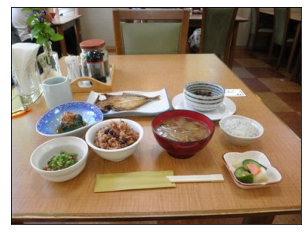

In [ ]:
image = cv2.imread('/content/drive/MyDrive/darknet/13273.jpg')
imagee = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(imagee) 
plt.xticks([]) 
plt.yticks([]) 
plt.show() 

# 이미지 detection 바운딩박스 정보출력

In [ ]:
detections, width_ratio, height_ratio = darknet_helper(imagee, width, height)
detections

[('rice',
  '74.37',
  (330.8217468261719,
   233.03665161132812,
   55.115665435791016,
   49.32010269165039)),
 ('miso soup',
  '82.0',
  (246.83096313476562,
   236.90647888183594,
   87.82862091064453,
   78.36955261230469))]

# 칼로리 표시하기

In [ ]:
import pandas as pd
# 칼로리가 포함된 txt파일 불러오기
data = pd.read_csv('/content/drive/MyDrive/category (1).txt',sep=',')
temp = data['name'].str.split('(')
temp

0                        [1\trice , 310kcal]
1                [2\teels on rice , 717kcal]
2                       [3\tpilaf , 625kcal]
3     [4\tchicken-'n'-egg on rice , 647kcal]
4         [5\tpork cutlet on rice , 650kcal]
                       ...                  
95           [96\tdipping noodles , 206kcal]
96                 [97\thot dog , 289.7kcal]
97            [98\tfrench fries , 311.0kcal]
98                [99\tmixed rice , 216kcal]
99     [100\tgoya chanpuru , 272kcal. 227g)]
Name: name, Length: 100, dtype: object

In [ ]:
kcal_list = {}
# 음식이름과 칼로리 dict형식으로 매칭시켜놓기
for t in temp:
  if len(t)==2:
    index = t[0].split('\t')[1].strip(' ')
    kcal_list[index] = t[1]

kcal_list

{'Japanese tofu and vegetable chowder': '88kcal',
 'Japanese-style pancake': '490kcal',
 'beef bowl': '616kcal',
 'beef curry': '653kcal',
 'bibimbap': '703kcal',
 'boiled chicken and vegetables': '158kcal',
 'chicken rice': '350kcal',
 "chicken-'n'-egg on rice": '647kcal',
 'chilled noodle': '27kcal',
 'chinese soup': '77kcal',
 'croissant': '227kcal',
 'croquette': '358kcal',
 'cutlet curry': '158kcal',
 'dipping noodles': '206kcal',
 'eels on rice': '717kcal',
 'egg roll': '130kcal',
 'fish-shaped pancake with bean jam': '265kcal',
 'french fries': '311.0kcal',
 'fried rice': '250kcal',
 'fried shrimp': '287kcal',
 'goya chanpuru': '272kcal. 227g)',
 'gratin': '131kca',
 'green salad': '17kcal',
 'grilled eggplant': '108kcal',
 'grilled salmon': '99kcal',
 'hamburger': '270kcal',
 'hot dog': '289.7kcal',
 'jiaozi': '280kcal',
 'kinpira-style sauteed burdock': '135kcal',
 'macaroni salad': '290kacl',
 'miso soup': '84kcal',
 'mixed rice': '216kcal',
 'oden': '135kcal',
 'omelet': '15

In [ ]:
food_list = detections
# 감지된 음식 이름에 해당하는 kcal 표시하기
for food in food_list:
  print(kcal_list[food[0]])

310kcal
84kcal


# 사진에 바운딩박스와 칼로리 표시하기

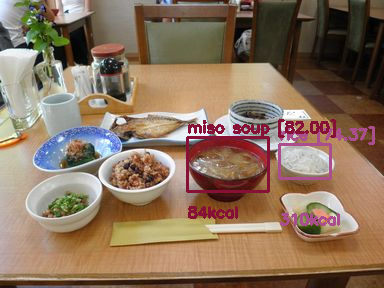

총 칼로리 : 394


In [ ]:
kcal_sum = 0
for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(imagee, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(imagee, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
  cv2.putText(imagee,kcal_list[label],
              (left, top+80), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
              class_colors[label], 2)
  kcal_sum+=int(kcal_list[label].strip('kcal'))
image = cv2.cvtColor(imagee, cv2.COLOR_RGB2BGR)
cv2_imshow(image)
print(f"총 칼로리 : {kcal_sum}")

# 개선점
1. 영양소 정보도 추가하기
2. 더많은 iteration 돌리기